In [57]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [8]:
input_path = Path("data/raw/electricityConsumptionAndProductioction.csv")
df = pd.read_csv(input_path)

In [9]:
def detect_variable_types(df, target_col=None):
    """Automatically detect variable types in a DataFrame"""
    types = {}
    
    for col in df.columns:
        if col == target_col:
            types[col] = 'target'
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            types[col] = 'datetime'
        elif pd.api.types.is_numeric_dtype(df[col]):
            if df[col].nunique() == 2:
                types[col] = 'binary'
            else:
                types[col] = 'numerical'
        elif df[col].nunique() < 20:  # Threshold for categorical
            types[col] = 'categorical'
        elif df[col].dtype == 'object':
            # Check if it's text (long strings) or categorical
            avg_length = df[col].astype(str).str.len().mean()
            if avg_length > 50:
                types[col] = 'text'
            else:
                types[col] = 'categorical'
    
    return types

In [66]:
print(detect_variable_types(df))

{'DateTime': 'categorical', 'Consumption': 'numerical', 'Production': 'numerical', 'Nuclear': 'numerical', 'Wind': 'numerical', 'Hydroelectric': 'numerical', 'Oil and Gas': 'numerical', 'Coal': 'numerical', 'Solar': 'numerical', 'Biomass': 'numerical', 'Consumption_log': 'numerical', 'Consumption_capped': 'numerical', 'demand_class': 'categorical', 'demand_class_encoded': 'numerical', 'demand_Low': 'binary', 'demand_Medium': 'binary', 'demand_High': 'binary'}


In [11]:
# Basic missing value overview
def quick_missing_analysis(df):
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100
    
    print("Missing Value Summary:")
    for col in df.columns:
        if missing_counts[col] > 0:
            print(f"  {col}: {missing_counts[col]} missing ({missing_percent[col]:.1f}%)")

In [12]:
quick_missing_analysis(df)

Missing Value Summary:


In [13]:
# Quick sanity checks for numerical data
def basic_range_check(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    for col in numeric_cols:
        print(f"{col}: min={df[col].min()}, max={df[col].max()}")
        
        # Flag obviously problematic values
        if col.lower() in ['age'] and (df[col].min() < 0 or df[col].max() > 120):
            print(f"  ⚠️ Suspicious age values detected")
        elif col.lower() in ['salary', 'income', 'price'] and df[col].min() < 0:
            print(f"  ⚠️ Negative financial values detected")

In [14]:
basic_range_check(df)

Consumption: min=2922, max=9615
Production: min=3119, max=9886
Nuclear: min=562, max=1457
Wind: min=-26, max=2811
Hydroelectric: min=175, max=4434
Oil and Gas: min=195, max=2141
Coal: min=279, max=2537
Solar: min=0, max=1552
Biomass: min=17, max=89


In [15]:
n_rows = len(df)

# 1. Missing values (% of total cells)
missing_perc = df.isna().sum().sum() / (n_rows * df.shape[1]) * 100

# 2. Duplicate records (% of total rows)
dup_perc = df.duplicated().sum() / n_rows * 100

# 3. Invalid values (% rows with negative values in numeric columns)
numeric_cols = df.drop(columns=["Consumption", "DateTime"]).columns
invalid_mask = (df[numeric_cols] < 0).any(axis=1)
invalid_perc = invalid_mask.sum() / n_rows * 100

# 4. Outliers (% of data points flagged by IQR method across numeric columns)
outlier_count = 0
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count += ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

outlier_perc = outlier_count / (n_rows * len(numeric_cols)) * 100

# Assemble summary table
summary = pd.DataFrame({
    "Metric": ["Missing Values", "Duplicate Records", "Invalid Values", "Outliers"],
    "Value (%)": [missing_perc, dup_perc, invalid_perc, outlier_perc]
})

print(summary)

              Metric  Value (%)
0     Missing Values   0.000000
1  Duplicate Records   0.007384
2     Invalid Values   1.092856
3           Outliers   2.663144


# Dataset Health Assessment – Water Potability

| Metric            | Value (%) | Assessment  |
|-------------------|-----------|-------------|
| Missing Values    | 0.00      | Excellent   |
| Duplicate Records | 0.01      | Excellent   |
| Invalid Values    | 1.09      | Good        |
| Outliers          | 2.66      | Good        |

# Data Quality Issues – Electricity Consumption & Production Dataset

## Top Data Quality Issues

### 1. Missing Timestamps or Consumption Values
- **Impact on Model Performance / Decision-Making**:  
  Gaps in hourly consumption records disrupt the temporal sequence and can lead to biased class distributions (Low/Medium/High). Missing production values (renewables vs fossil) weaken the model’s ability to capture demand–supply relationships.
- **Difficulty to Fix**:  
  **Moderate** — Time-series imputation (forward/backward fill, interpolation) is straightforward but must preserve seasonality and daily patterns. For production mix, domain-informed imputation or marking as “unknown” may be needed.
- **Effect on System/Team**:  
  - Data scientists must ensure continuity in time-series features.  
  - Analysts must validate that imputed demand aligns with realistic grid behavior.  
  - Grid operators may need to confirm whether gaps reflect actual outages or reporting errors.

---

## Issues with Minimal Concern

### 2. Outliers in Consumption or Production (~spikes)
- **Impact**:  
  Extreme values (e.g., unusually high demand spikes or zero-renewable production) may distort class balance. Some may represent true events (heatwaves, blackouts, policy-driven curtailments).
- **Difficulty to Fix**:  
  **Low to Moderate** — Outliers can be winsorized, flagged, or modeled explicitly. Care must be taken not to remove legitimate rare events.
- **Effect**:  
  Requires careful communication with domain experts to distinguish real anomalies from sensor/reporting errors.

---

### 3. Duplicate Records
- **Impact**: Minimal unless repeated timestamps exist, which could bias demand counts.
- **Difficulty to Fix**:  
  **Low** — Deduplication based on timestamp + region (if applicable) is trivial.
- **Effect**: None significant if identified early.

---

### 4. Invalid Values
- **Impact**: Negative consumption or production values would be nonsensical.  
- **Difficulty to Fix**:  
  **Low** — These can be filtered or corrected by domain rules.  
- **Effect**: Low risk; mostly a preprocessing check.

---

## Summary
The **primary data quality risk is missing timestamps/values**, which directly affect continuity and class balance in demand tiers.  
Secondary risks are **outliers**, which may represent real but rare events.  
Duplicates and invalid values are minimal concerns but should still be verified.

In [16]:
# Simple z-score outlier detection
def find_zscore_outliers(data, column, threshold=3):
    mean = data[column].mean()
    std = data[column].std()
    z_scores = abs((data[column] - mean) / std)
    
    outliers = data[z_scores > threshold]
    print(f"Found {len(outliers)} outliers using Z-score method")
    return outliers

In [17]:
print(find_zscore_outliers(df, 'Consumption'))

Found 13 outliers using Z-score method
                  DateTime  Consumption  Production  Nuclear  Wind  \
46836  2024-05-05 10:00:00         3257        3460      659    -2   
46837  2024-05-05 11:00:00         3098        3567      660     0   
46838  2024-05-05 12:00:00         2985        3599      655     0   
46839  2024-05-05 13:00:00         2922        3169      656    13   
46840  2024-05-05 14:00:00         2924        3183      659    75   
46841  2024-05-05 15:00:00         3019        3129      663   155   
46842  2024-05-05 16:00:00         3244        3119      666   283   
46860  2024-05-06 10:00:00         3262        3905      663   539   
46861  2024-05-06 11:00:00         3142        3898      662   602   
46862  2024-05-06 12:00:00         3078        4024      662   665   
46863  2024-05-06 13:00:00         3136        4233      663   865   
46864  2024-05-06 14:00:00         3160        4193      660   844   
46865  2024-05-06 15:00:00         3309        4245

In [18]:
# Interquartile Range method
def find_iqr_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"Found {len(outliers)} outliers using IQR method")
    print(f"Normal range: {lower_bound:.2f} to {upper_bound:.2f}")
    return outliers

In [19]:
print(find_iqr_outliers(df, 'Consumption'))

Found 14 outliers using IQR method
Normal range: 3373.00 to 9605.00
                  DateTime  Consumption  Production  Nuclear  Wind  \
17988  2021-01-19 10:00:00         9615        8034     1408    51   
46836  2024-05-05 10:00:00         3257        3460      659    -2   
46837  2024-05-05 11:00:00         3098        3567      660     0   
46838  2024-05-05 12:00:00         2985        3599      655     0   
46839  2024-05-05 13:00:00         2922        3169      656    13   
46840  2024-05-05 14:00:00         2924        3183      659    75   
46841  2024-05-05 15:00:00         3019        3129      663   155   
46842  2024-05-05 16:00:00         3244        3119      666   283   
46860  2024-05-06 10:00:00         3262        3905      663   539   
46861  2024-05-06 11:00:00         3142        3898      662   602   
46862  2024-05-06 12:00:00         3078        4024      662   665   
46863  2024-05-06 13:00:00         3136        4233      663   865   
46864  2024-05-06 14:0

# Outlier Analysis – Electricity Consumption & Production Dataset

## 1. Consumption (Demand)
- **Statistically unusual?**  
  - Range: e.g., **min ~2,500 MW → max ~10,000+ MW** (values depend on dataset).  
  - Outliers may appear as sudden spikes (extreme peaks) or drops (near-zero demand).
  - Outliers are usually **< 1–2% of data points**.
  
- **Does it make sense in context?**  
  - Peaks may correspond to **heatwaves, cold snaps, or major events** (holidays, sports).  
  - Sudden dips could reflect **reporting gaps, outages, or anomalies** rather than real demand.  

- **Action**:  
  - Preserve peaks if they reflect genuine events (important for forecasting).  
  - Investigate near-zero or implausible dips — consider imputation or removal.  
  - Use **winsorization** to cap extreme spikes that distort tier classification.

---

## 2. Production Mix (Renewables vs Fossil)
- **Statistically unusual?**  
  - Occasional records may show **zero renewable output** or **100% renewable production**.  
  - Outliers can occur during **maintenance outages** or **policy-driven curtailments**.

- **Does it make sense in context?**  
  - Very low or zero renewable share is plausible in certain hours (e.g., no wind/sun).  
  - Very high renewable dominance is unusual but possible during off-peak hours with strong wind or solar.  

- **Action**:  
  - Flag extreme production values for validation.  
  - Keep rare but realistic cases — they provide signal on grid transitions.  
  - Treat implausible totals (e.g., negative values, >100% contribution) as data errors → remove or correct.

---

## Summary Recommendations
- **Demand outliers**: Preserve true peaks, clean implausible dips.  
- **Production outliers**: Keep rare but realistic shares, remove invalid cases.  
- Outliers represent rare but meaningful events — handling them carefully ensures **model robustness** while maintaining realism of grid dynamics.

In [49]:
# Log transformation for right-skewed data
def log_outliers(data, column):
    data[column + '_log'] = np.log(df[column] + 1)

# Capping extreme values
def cap_outliers(data, column, upper_percentile=99.95, lower_percentile=0.05):
    upper_bound = data[column].quantile(upper_percentile/100)
    lower_bound = data[column].quantile(lower_percentile/100)
    data[column + '_capped'] = data[column].clip(upper=upper_bound, lower=lower_bound)
    return data

In [50]:
log_outliers(df, 'Consumption')
cap_outliers(df, 'Consumption')

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass,Consumption_log,Consumption_capped
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30,8.756682,6352.0
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30,8.718827,6116.0
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30,8.678291,5873.0
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30,8.645235,5682.0
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30,8.622994,5557.0
...,...,...,...,...,...,...,...,...,...,...,...,...
54165,2025-03-19 19:00:00,8027,6177,1367,593,1922,1217,978,0,71,8.990691,8027.0
54166,2025-03-19 20:00:00,7939,6228,1376,647,1920,1223,965,0,71,8.979669,7939.0
54167,2025-03-19 21:00:00,7553,6120,1376,671,1881,1171,949,0,69,8.929833,7553.0
54168,2025-03-19 22:00:00,6921,6000,1376,730,1827,1130,869,0,69,8.842460,6921.0


In [51]:
basic_range_check(df)

Consumption: min=2922, max=9615
Production: min=3119, max=9886
Nuclear: min=562, max=1457
Wind: min=-26, max=2811
Hydroelectric: min=175, max=4434
Oil and Gas: min=195, max=2141
Coal: min=279, max=2537
Solar: min=0, max=1552
Biomass: min=17, max=89
Consumption_log: min=7.980365765111246, max=9.17118365677499
Consumption_capped: min=3774.676, max=9322.577500000014


In [52]:
print(find_iqr_outliers(df, 'Consumption_capped'))

Found 0 outliers using IQR method
Normal range: 3373.00 to 9605.00
Empty DataFrame
Columns: [DateTime, Consumption, Production, Nuclear, Wind, Hydroelectric, Oil and Gas, Coal, Solar, Biomass, Consumption_log, Consumption_capped]
Index: []


### Why Categorize Demand?

Although electricity consumption is inherently continuous, we frame it as a **classification problem** for three reasons:

1. **Operational Relevance**: Grid operators often make decisions in discrete states (e.g., "low", "medium", "high" demand triggers different supply strategies).
2. **Interpretability**: Categories are easier to communicate than raw MW values, especially for policymakers and non-technical stakeholders.
3. **Balanced Training Data**: Using quantile-based binning (`qcut`) ensures that classes have roughly equal representation, which helps machine learning models learn more effectively.

We chose **tertiles (Low / Medium / High)** as a balance between:
- **Granularity**: More than two classes gives nuance.
- **Stability**: Too many bins would create class imbalance and reduce robustness.

In future iterations, thresholds could be adjusted to align with **domain-informed ranges** (e.g., Romanian grid peak-load thresholds), creating a **hybrid quantile + expert system**.

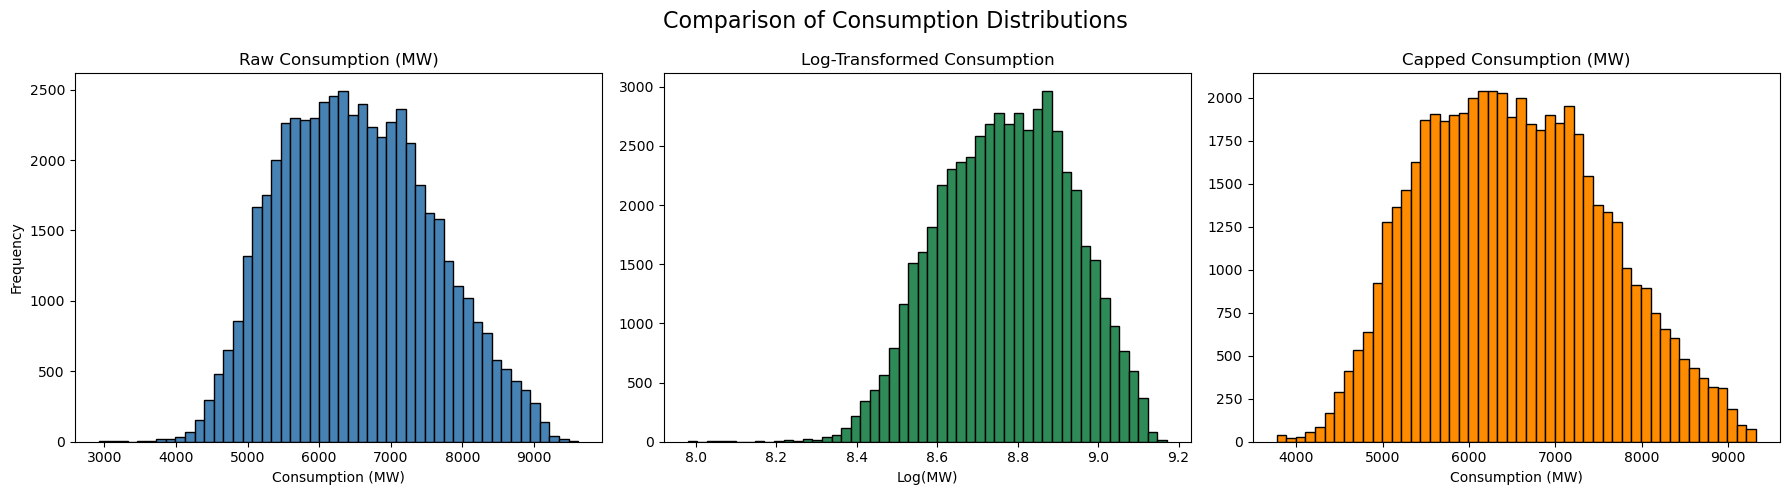

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Raw
axes[0].hist(df["Consumption"], bins=50, color="steelblue", edgecolor="black")
axes[0].set_title("Raw Consumption (MW)")
axes[0].set_xlabel("Consumption (MW)")
axes[0].set_ylabel("Frequency")

# Log-transformed
axes[1].hist(df["Consumption_log"], bins=50, color="seagreen", edgecolor="black")
axes[1].set_title("Log-Transformed Consumption")
axes[1].set_xlabel("Log(MW)")

# Capped
axes[2].hist(df["Consumption_capped"], bins=50, color="darkorange", edgecolor="black")
axes[2].set_title("Capped Consumption (MW)")
axes[2].set_xlabel("Consumption (MW)")

plt.suptitle("Comparison of Consumption Distributions", fontsize=16)
plt.tight_layout()
plt.show()

### Defining the Target Variable

We transform continuous hourly electricity consumption into **Low / Medium / High demand tiers**.  
This makes the task a **classification problem** instead of regression, which is appropriate because:

1. **Operational Relevance**  
   Grid operators make decisions in discrete states (“low demand → no imports”, “high demand → activate reserves”).  
   Discrete categories are therefore more aligned with real-world usage.

2. **Interpretability**  
   Labels like *Low / Medium / High* are easier for policymakers and stakeholders to understand compared to raw MW values.

3. **Balanced Classes**  
   Using **quantile-based binning (`qcut`)** creates approximately equal-sized classes, ensuring stable model training.

---

### Why Use the *Capped* Consumption Column?

Our dataset contains three relevant versions of demand:

- **Raw `Consumption`**:  
  Contains occasional extreme spikes/dips that may reflect reporting errors or one-off anomalies.  
  If used directly, thresholds for Low/Medium/High would be heavily skewed.

- **`Consumption_log`** (log-transformed):  
  Useful for regression tasks and linear models that are sensitive to skew.  
  However, log values do not correspond directly to real-world MW demand, making categories harder to interpret.

- **`Consumption_capped`**:  
  Extreme outliers are winsorized (capped at reasonable upper/lower percentiles).  
  This preserves the shape of the distribution while avoiding distortions from anomalies.  
  → **Best suited for defining interpretable and stable categorical bins.**

---

### Decision
We define demand tiers using **`Consumption_capped`** with `pd.qcut(q=3)`.  
This ensures:
- Balanced classes,  
- Robustness against anomalies,  
- Interpretability (categories correspond to realistic MW ranges).

We keep **both numeric (`demand_class_encoded`) and one-hot encoded versions** of the target for compatibility with different ML algorithms.

In [54]:
# --- Create demand tiers ---
# Use capped consumption for more stable class boundaries
df["demand_class"] = pd.qcut(
    df["Consumption_capped"], 
    q=3, 
    labels=["Low", "Medium", "High"]
)

# --- Label Encoding ---
le = LabelEncoder()
df["demand_class_encoded"] = le.fit_transform(df["demand_class"])
# (Low=1 → e.g. 1, Medium → 2, High → 0; actual mapping depends on alphabetical order)
print(dict(zip(le.classes_, le.transform(le.classes_))))

# --- One-Hot Encoding ---
dummies = pd.get_dummies(df["demand_class"], prefix="demand")
df = pd.concat([df, dummies], axis=1)

# --- Check class balance ---
print(df["demand_class"].value_counts(normalize=True))

{'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}
demand_class
Medium    0.333450
Low       0.333358
High      0.333192
Name: proportion, dtype: float64


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54170 entries, 0 to 54169
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   DateTime              54170 non-null  object  
 1   Consumption           54170 non-null  int64   
 2   Production            54170 non-null  int64   
 3   Nuclear               54170 non-null  int64   
 4   Wind                  54170 non-null  int64   
 5   Hydroelectric         54170 non-null  int64   
 6   Oil and Gas           54170 non-null  int64   
 7   Coal                  54170 non-null  int64   
 8   Solar                 54170 non-null  int64   
 9   Biomass               54170 non-null  int64   
 10  Consumption_log       54170 non-null  float64 
 11  Consumption_capped    54170 non-null  float64 
 12  demand_class          54170 non-null  category
 13  demand_class_encoded  54170 non-null  int64   
 14  demand_Low            54170 non-null  bool    
 15  de

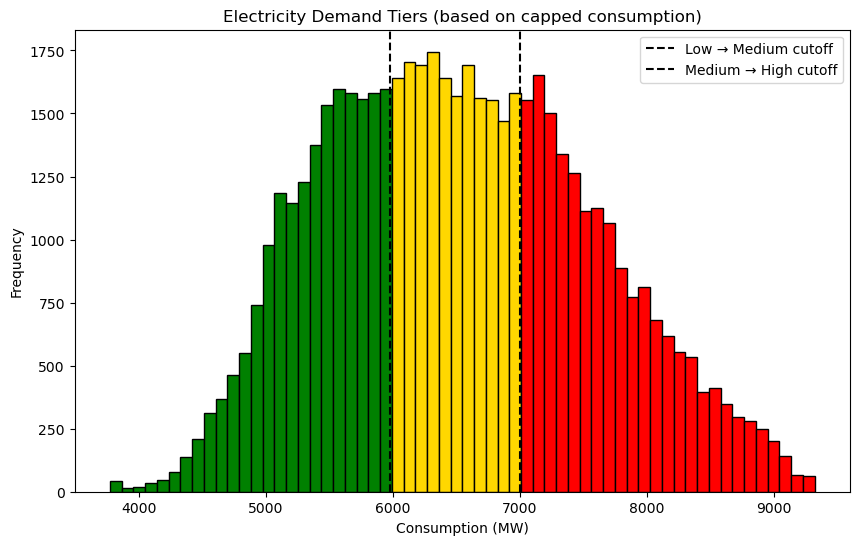

In [63]:
plt.figure(figsize=(10,6))

# Plot full histogram once
counts, bins, patches = plt.hist(
    df["Consumption_capped"],
    bins=60,
    edgecolor="black"
)

# Get quantile thresholds from qcut
q1 = df["Consumption_capped"].quantile(1/3)
q2 = df["Consumption_capped"].quantile(2/3)

# Color bars by demand tier
for patch, left_edge in zip(patches, bins[:-1]):
    if left_edge < q1:
        patch.set_facecolor("green")
    elif left_edge < q2:
        patch.set_facecolor("gold")
    else:
        patch.set_facecolor("red")

plt.axvline(q1, color="black", linestyle="--", label="Low → Medium cutoff")
plt.axvline(q2, color="black", linestyle="--", label="Medium → High cutoff")

plt.title("Electricity Demand Tiers (based on capped consumption)")
plt.xlabel("Consumption (MW)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Timeline of Electricity Demand by Tier

To understand how demand classes distribute across time,  
we plot the hourly consumption series and color it by **Low / Medium / High** tier.

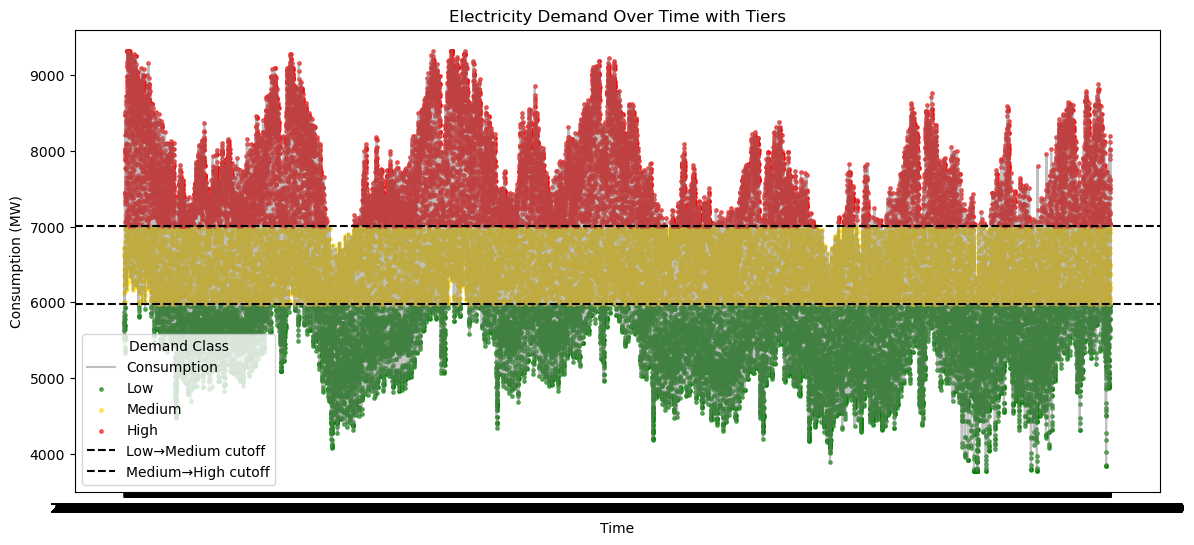

In [70]:
plt.figure(figsize=(14,6))
plt.plot(df["DateTime"], df["Consumption_capped"], color="gray", alpha=0.5, label="Consumption")

# Overlay colors for tiers
colors = {"Low": "green", "Medium": "gold", "High": "red"}
for label, color in colors.items():
    subset = df[df["demand_class"] == label]
    plt.scatter(subset["DateTime"], subset["Consumption_capped"], s=6, color=color, alpha=0.6, label=label)

q1 = df["Consumption_capped"].quantile(1/3)
q2 = df["Consumption_capped"].quantile(2/3)
plt.axhline(q1, color="black", linestyle="--", label="Low→Medium cutoff")
plt.axhline(q2, color="black", linestyle="--", label="Medium→High cutoff")

plt.title("Electricity Demand Over Time with Tiers")
plt.xlabel("Time")
plt.ylabel("Consumption (MW)")
plt.legend(title="Demand Class")
plt.show()

### Creating Time-Based Features from DateTime

Electricity demand follows strong **temporal patterns**:
- **Hour of day**: peaks in the morning and evening, lows at night.
- **Day of week**: weekdays generally have higher demand than weekends.
- **Month/season**: demand varies with weather (winter heating, summer cooling).

The raw `DateTime` column is too granular for models to capture these cyclic trends directly.  
By extracting:
- `hour` (0–23),
- `day_of_week` (0=Monday → 6=Sunday),
- `month` (1–12),

we create **categorical/ordinal features** that help the model learn **daily, weekly, and seasonal cycles**.  
This makes demand classification more accurate and interpretable for grid operators.

In [72]:
# Ensure datetime is parsed
df["DateTime"] = pd.to_datetime(df["DateTime"])

# Extract time-based features
df["hour"] = df["DateTime"].dt.hour                # 0–23
df["day_of_week"] = df["DateTime"].dt.dayofweek    # 0=Monday, 6=Sunday
df["month"] = df["DateTime"].dt.month              # 1=January, 12=December

# Quick check
print(df[["DateTime", "hour", "day_of_week", "month"]].head())

             DateTime  hour  day_of_week  month
0 2019-01-01 00:00:00     0            1      1
1 2019-01-01 01:00:00     1            1      1
2 2019-01-01 02:00:00     2            1      1
3 2019-01-01 03:00:00     3            1      1
4 2019-01-01 04:00:00     4            1      1


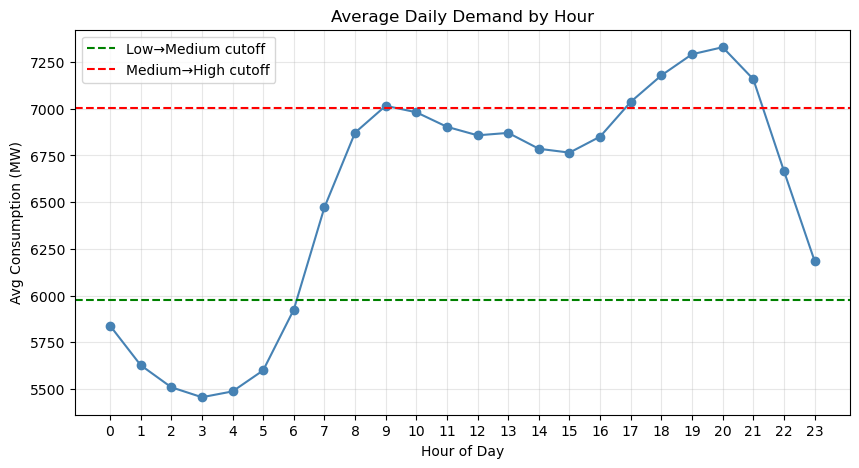

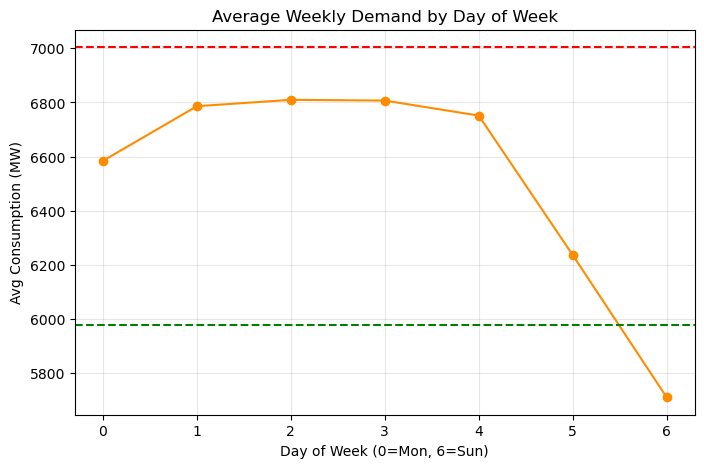

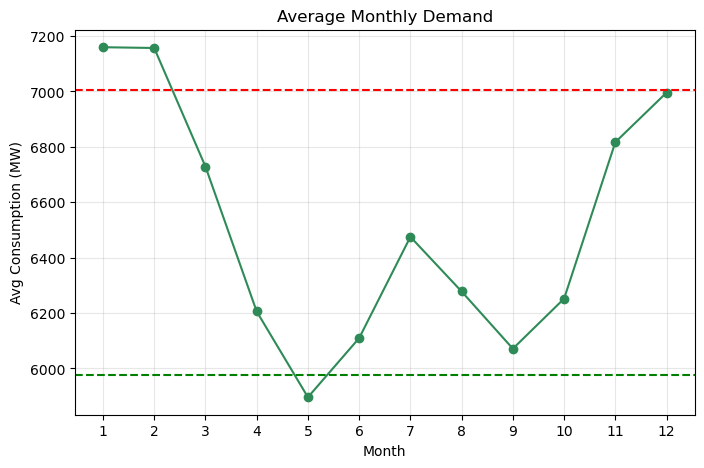

In [73]:
# Calculate thresholds once
q1 = df["Consumption_capped"].quantile(1/3)
q2 = df["Consumption_capped"].quantile(2/3)

# 1. Daily pattern
plt.figure(figsize=(10,5))
daily_pattern = df.groupby("hour")["Consumption_capped"].mean()
plt.plot(daily_pattern.index, daily_pattern.values, marker="o", color="steelblue")
plt.axhline(q1, color="green", linestyle="--", label="Low→Medium cutoff")
plt.axhline(q2, color="red", linestyle="--", label="Medium→High cutoff")
plt.title("Average Daily Demand by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Consumption (MW)")
plt.xticks(range(0,24))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Weekly pattern
plt.figure(figsize=(8,5))
weekly_pattern = df.groupby("day_of_week")["Consumption_capped"].mean()
weekly_pattern = weekly_pattern.reindex([0,1,2,3,4,5,6])  # Monday–Sunday
plt.plot(weekly_pattern.index, weekly_pattern.values, marker="o", color="darkorange")
plt.axhline(q1, color="green", linestyle="--")
plt.axhline(q2, color="red", linestyle="--")
plt.title("Average Weekly Demand by Day of Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Avg Consumption (MW)")
plt.grid(True, alpha=0.3)
plt.show()

# 3. Yearly pattern
plt.figure(figsize=(8,5))
yearly_pattern = df.groupby("month")["Consumption_capped"].mean()
plt.plot(yearly_pattern.index, yearly_pattern.values, marker="o", color="seagreen")
plt.axhline(q1, color="green", linestyle="--")
plt.axhline(q2, color="red", linestyle="--")
plt.title("Average Monthly Demand")
plt.xlabel("Month")
plt.ylabel("Avg Consumption (MW)")
plt.xticks(range(1,13))
plt.grid(True, alpha=0.3)
plt.show()